In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Check if the directory exists
WORK_DIR = "/content/drive/My Drive/BigDataProject"
if os.path.exists(WORK_DIR):
    print("✅ Directory exists:", WORK_DIR)
    os.chdir(WORK_DIR)
    print("✅ Changed working directory to:", os.getcwd())
else:
    print("❌ Directory not found! Check your Drive mount.")


✅ Directory exists: /content/drive/My Drive/BigDataProject
✅ Changed working directory to: /content/drive/My Drive/BigDataProject


In [ ]:
# List files to confirm your dataset exists
files = os.listdir(WORK_DIR)
print("📂 Files in project directory:", files)

# Ensure 'data.csv' is available
if "data.csv" in files:
    print("✅ 'data.csv' found!")
else:
    print("❌ 'data.csv' is missing! Please upload it to your Drive.")

📂 Files in project directory: ['holdout_metrics_precio.xlsx', 'data.csv', 'holdout_metrics_generacion.xlsx', 'holdout_metrics_demanda.xlsx', '__pycache__', 'data.gsheet', 'results', 'saved_models', 'saul']
✅ 'data.csv' found!


In [ ]:
import pandas as pd

DATA_FILE = os.path.join(WORK_DIR, "data.csv")

# Load data if file exists
if os.path.exists(DATA_FILE):
    df = pd.read_csv(DATA_FILE, sep=';', parse_dates=['datetime'])
    print("✅ Data loaded successfully!")
    print(df.head())  # Show first rows
else:
    print("❌ Data file not found! Upload 'data.csv' to Google Drive.")

✅ Data loaded successfully!
                    datetime  gen_total  gen_renovable_nuclear  gen_eolica  \
0  2023-03-01 00:00:00+01:00   26622.50               23039.92     9765.42   
1  2023-03-01 01:00:00+01:00   24967.42               21344.75     9419.50   
2  2023-03-01 02:00:00+01:00   23877.75               19962.08     8676.58   
3  2023-03-01 03:00:00+01:00   23528.00               19405.75     8273.25   
4  2023-03-01 04:00:00+01:00   23461.08               18922.58     8025.08   

   gen_nuclear  gen_hidraulica  gen_solar  gen_renovable  otras_renovables  \
0      6094.50         3892.50     271.00       14490.67            561.75   
1      6095.08         2730.67      93.67       12787.42            543.58   
2      6095.17         2161.08      36.33       11411.42            537.42   
3      6094.33         2027.92      13.00       10850.25            536.08   
4      6096.00         1792.92      13.00       10367.00            536.00   

   gen_cogen_resto  ...  rain_(mm)

In [ ]:
!pip install xgboost statsmodels openpyxl --quiet

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from google.colab import drive

# Mount Google Drive for file access
drive.mount('/content/drive')

# Set working directory
WORK_DIR = "/content/drive/My Drive/BigDataProject"
os.makedirs(f"{WORK_DIR}/results", exist_ok=True)
DATA_FILE = os.path.join(WORK_DIR, "data.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(file_path, target_column):
    """Load dataset and prepare datetime index."""
    df = pd.read_csv(file_path, sep=';', parse_dates=['datetime'])
    df.sort_values(by='datetime', inplace=True)
    df.set_index('datetime', inplace=True)
    df.dropna(subset=[target_column], inplace=True)
    return df

In [ ]:
def ml_train_test_split(df, target_column, holdout_hours=24):
    """Splits data into training and holdout set for ML models."""
    cutoff = df.index.max() - pd.Timedelta(hours=holdout_hours)
    train_df = df[df.index <= cutoff]
    holdout_df = df[df.index > cutoff]

    feature_cols = [col for col in df.columns if col != target_column]
    X_train, y_train = train_df[feature_cols], train_df[target_column]
    X_holdout, y_holdout = holdout_df[feature_cols], holdout_df[target_column]

    return X_train, y_train, X_holdout, y_holdout

In [ ]:
import joblib
import os
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Define directory for saved models
MODEL_DIR = os.path.join(WORK_DIR, "saved_models")
os.makedirs(MODEL_DIR, exist_ok=True)

def train_ml_models(X_train, y_train, target_column):
    """Train ML models and save them to Google Drive if not already saved."""
    model_paths = {
        'XGBoost': os.path.join(MODEL_DIR, f"xgboost_{target_column}.joblib"),
        'DecisionTree': os.path.join(MODEL_DIR, f"decision_tree_{target_column}.joblib"),
        'RandomForest': os.path.join(MODEL_DIR, f"random_forest_{target_column}.joblib")
    }

    models = {
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=20, random_state=42)
    }

    trained_models = {}
    for name, model in models.items():
        if os.path.exists(model_paths[name]):  # Check if model exists
            print(f"🔄 Loading saved {name} model for {target_column}...")
            trained_models[name] = joblib.load(model_paths[name])
            print(f"✅ Successfully loaded {name} model for {target_column}.")
        else:
            print(f"⚡ Training {name} for {target_column}...")
            model.fit(X_train, y_train)
            joblib.dump(model, model_paths[name])  # Save model
            trained_models[name] = model
            print(f"✅ {name} model saved: {model_paths[name]}")

    return trained_models

In [ ]:
def cross_validate(X, y, models, n_splits=5):
    """Perform time series cross-validation and return results."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {name: [] for name in models}

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            results[name].append({
                "R2": r2_score(y_test, y_pred),
                "MAE": mean_absolute_error(y_test, y_pred),
                "MSE": mean_squared_error(y_test, y_pred),
                "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
            })

    return results

In [ ]:
def arima_train_test_split(df, target_column, holdout_hours=24):
    """Splits data into train and holdout for ARIMA (Univariate)."""
    cutoff = df.index.max() - pd.Timedelta(hours=holdout_hours)
    train_series = df.loc[df.index <= cutoff, target_column]
    holdout_series = df.loc[df.index > cutoff, target_column]

    return train_series, holdout_series

In [ ]:
import joblib
import os
from statsmodels.tsa.arima.model import ARIMA

def train_arima(y_train, target_column, p_range=(0,3), d_range=(0,2), q_range=(0,3)):
    """Train ARIMA model and save it to Google Drive if not already saved."""
    model_path = os.path.join(MODEL_DIR, f"arima_{target_column}.joblib")

    # 🔄 Check if an ARIMA model is already saved, and load it
    if os.path.exists(model_path):
        print(f"🔄 Loading saved ARIMA model for {target_column}...")
        return joblib.load(model_path)

    # 🚀 Perform ARIMA hyperparameter tuning if no saved model is found
    best_aic, best_order, best_model = float('inf'), None, None
    for p in range(*p_range):
        for d in range(*d_range):
            for q in range(*q_range):
                try:
                    model = ARIMA(y_train, order=(p,d,q)).fit()
                    if model.aic < best_aic:
                        best_aic, best_order, best_model = model.aic, (p,d,q), model
                except:
                    continue

    print(f"✅ Best ARIMA Order for {target_column}: {best_order} with AIC: {best_aic}")

    # 💾 Save the trained ARIMA model
    joblib.dump(best_model, model_path)
    print(f"✅ ARIMA model saved: {model_path}")

    return best_model

In [ ]:
def forecast_models(models, X_holdout):
    """Generate ML-based forecasts."""
    return {name: model.predict(X_holdout) for name, model in models.items()}

def forecast_arima(arima_model, steps=12):
    """Generate ARIMA forecasts."""
    return arima_model.forecast(steps=steps)

def save_results(results, file_path):
    """Save model performance metrics to an Excel file."""
    with pd.ExcelWriter(file_path) as writer:
        for model, scores in results.items():
            pd.DataFrame(scores).to_excel(writer, sheet_name=model)
    print(f"✅ Model performance saved at: {file_path}")

import pandas as pd

def save_forecasts(ml_predictions, arima_predictions, file_path):
    """Save ML & ARIMA forecast results to an Excel file."""
    with pd.ExcelWriter(file_path) as writer:
        # Save ML predictions
        pd.DataFrame(ml_predictions).to_excel(writer, sheet_name="ML_Forecasts")

        # Save ARIMA predictions (only for 'price')
        if arima_predictions is not None:
            pd.DataFrame({'ARIMA': arima_predictions}).to_excel(writer, sheet_name="ARIMA_Forecasts")

    print(f"✅ Forecast results saved at: {file_path}")

In [ ]:
def load_forecasts(file_path):
    """Load saved forecasts from an Excel file."""
    if os.path.exists(file_path):
        print(f"🔄 Loading forecasts from {file_path}...")
        return pd.read_excel(file_path, sheet_name=None)
    else:
        print(f"❌ Forecast file {file_path} not found!")
        return None

Here, we aim to use data usage best practices, by saving the models to save time and resources
As for the Statistical models, new data that enters can take advantage of bootstraping because the new data does not change the previous

In [ ]:
TARGET_COLUMNS = ["demand", "gen_total", "price"]
RESULTS_DIR = os.path.join(WORK_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

def run_all_models(file_path, target_columns):
    """Run ML and ARIMA models for each target variable, save results, and return predictions for visualization."""

    all_y_holdout = {}
    all_ml_predictions = {}
    all_y_holdout_arima = {}
    all_arima_predictions = {}
    all_cv_results = {}

    for target_column in target_columns:
        print(f"\n🚀 Processing target: {target_column.upper()}")

        df = load_data(file_path, target_column)

        # ML Models
        X_train, y_train, X_holdout, y_holdout = ml_train_test_split(df, target_column)
        ml_models = train_ml_models(X_train, y_train, target_column)
        cv_results = cross_validate(X_train, y_train, ml_models)

        # ✅ Save cross-validation results
        cv_results_path = os.path.join(RESULTS_DIR, f"cv_results_{target_column}.xlsx")
        save_results(cv_results, cv_results_path)

        # ✅ Generate ML Predictions
        ml_predictions = forecast_models(ml_models, X_holdout)

        # Store ML Predictions & Actual Values
        all_y_holdout[target_column] = y_holdout
        all_ml_predictions[target_column] = ml_predictions
        all_cv_results[target_column] = cv_results

        # ARIMA Model (Only for `price`)
        if target_column == "price":
            y_train_arima, y_holdout_arima = arima_train_test_split(df, target_column)
            arima_model = train_arima(y_train_arima, target_column)
            arima_predictions = forecast_arima(arima_model, steps=len(y_holdout_arima))

            # Store ARIMA results
            all_y_holdout_arima[target_column] = y_holdout_arima
            all_arima_predictions[target_column] = arima_predictions
        else:
            arima_predictions = None  # Assign None for non-price targets

        # ✅ Save ML and ARIMA forecasts
        forecast_path = os.path.join(RESULTS_DIR, f"forecast_{target_column}.xlsx")
        save_forecasts(ml_predictions, arima_predictions, forecast_path)

        print(f"✅ Completed processing for {target_column}. Results saved in {RESULTS_DIR}\n")

    return all_y_holdout, all_ml_predictions, all_y_holdout_arima, all_arima_predictions, all_cv_results

# Execute the pipeline and store results
y_holdout_dict, ml_predictions_dict, y_holdout_arima_dict, arima_predictions_dict, cv_results_dict = run_all_models(DATA_FILE, TARGET_COLUMNS)


🚀 Processing target: DEMAND
🔄 Loading saved XGBoost model for demand...
✅ Successfully loaded XGBoost model for demand.
🔄 Loading saved DecisionTree model for demand...
✅ Successfully loaded DecisionTree model for demand.
🔄 Loading saved RandomForest model for demand...
✅ Successfully loaded RandomForest model for demand.
✅ Model performance saved at: /content/drive/My Drive/BigDataProject/results/cv_results_demand.xlsx
✅ Forecast results saved at: /content/drive/My Drive/BigDataProject/results/forecast_demand.xlsx
✅ Completed processing for demand. Results saved in /content/drive/My Drive/BigDataProject/results


🚀 Processing target: GEN_TOTAL
🔄 Loading saved XGBoost model for gen_total...
✅ Successfully loaded XGBoost model for gen_total.
🔄 Loading saved DecisionTree model for gen_total...
✅ Successfully loaded DecisionTree model for gen_total.
🔄 Loading saved RandomForest model for gen_total...
✅ Successfully loaded RandomForest model for gen_total.
✅ Model performance saved at: /c

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



## Visualization

In [ ]:
!pip install plotly --quiet
import os
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directories for saving results
PLOT_DIR = os.path.join(WORK_DIR, "results/plots")
os.makedirs(PLOT_DIR, exist_ok=True)

In [ ]:
def plot_raw_data(df, target_column):
    """Plot raw time series data."""
    fig = px.line(df, x=df.index, y=target_column, title=f"{target_column.upper()} Over Time")
    fig.update_layout(
        xaxis_title="Time",
        yaxis_title=f"{target_column.upper()} Value",
        template="plotly_dark"
    )
    fig.show()

# Example usage:
df = load_data(DATA_FILE, target_column="demand")
plot_raw_data(df, target_column="demand")

In [ ]:
import plotly.graph_objects as go

def plot_forecasts(y_true, ml_predictions, arima_predictions=None, target_column="target"):
    """Plot actual vs. predicted values for all ML models + ARIMA (if applicable)."""
    fig = go.Figure()

    # Plot Actual Values
    fig.add_trace(go.Scatter(
        x=y_true.index, y=y_true, mode="lines",
        name=f"Actual {target_column.upper()}", line=dict(color="black", width=2)
    ))

    # Plot ML Predictions (Solid Lines)
    for model_name, preds in ml_predictions.items():
        fig.add_trace(go.Scatter(
            x=y_true.index, y=preds, mode="lines",
            name=f"{model_name} (ML)", line=dict(width=1.5)
        ))

    # Plot ARIMA Predictions (Dashed Line, Only for Price)
    if arima_predictions is not None:
        fig.add_trace(go.Scatter(
            x=y_true.index, y=arima_predictions, mode="lines",
            name="ARIMA (Time Series)", line=dict(dash='dot', width=2, color="red")
        ))

    fig.update_layout(
        title=f"Forecast Comparison for {target_column.upper()}",
        xaxis_title="Time",
        yaxis_title="Value",
        legend_title="Model Used"
    )

    # Display the plot interactively
    fig.show()

    return fig  # Return the figure for any future use

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

def plot_model_performance(results, metric="R2"):
    """Visualize model performance across cross-validation folds."""
    # Create a DataFrame with the cross-validation results
    df_results = pd.DataFrame({model: [run[metric] for run in scores] for model, scores in results.items()})

    # Create a boxplot to show model performance
    fig = px.box(df_results, title=f"{metric} Performance Across Models",
                 labels={'value': metric, 'variable': 'Model'},
                 template="plotly_dark")

    # Display the plot interactively (without saving it)
    fig.show()

    return fig  # Return figure for saving if needed later

In [ ]:
PLOT_DIR = os.path.join(WORK_DIR, "results/plots")
os.makedirs(PLOT_DIR, exist_ok=True)

def save_plot(fig, filename):
    """Save Plotly figure as an image in Google Drive."""
    file_path = os.path.join(PLOT_DIR, filename)
    fig.write_image(file_path)
    print(f"✅ Plot saved: {file_path}")

In [ ]:
# Loop through all target variables and generate plots
for target_column in TARGET_COLUMNS:
    # Get the actual values for the target
    y_holdout = y_holdout_dict.get(target_column, None)

    # Get ML predictions for the target
    ml_predictions = ml_predictions_dict.get(target_column, None)

    # Generate Cross-Validation Plots (No saving, just displaying interactively)
    cv_results = cv_results_dict.get(target_column, None)
    if cv_results:
        # R2 performance
        plot_model_performance(cv_results, metric="R2")

        # MAE performance
        plot_model_performance(cv_results, metric="MAE")

        # RMSE performance
        plot_model_performance(cv_results, metric="RMSE")

    # Plot ML Predictions (No saving, just displaying interactively)
    if y_holdout is not None and ml_predictions is not None:
        plot_forecasts(y_holdout, ml_predictions, target_column=target_column)

    # For `price`, include ARIMA predictions
    if target_column == "price":
        y_holdout_arima = y_holdout_arima_dict.get(target_column, None)
        arima_predictions = arima_predictions_dict.get(target_column, None)

        if y_holdout_arima is not None and ml_predictions is not None and arima_predictions is not None:
            plot_forecasts(y_holdout_arima, ml_predictions, arima_predictions, target_column=target_column)
    else:
        # For non-price targets, no ARIMA predictions are used
        arima_predictions = None  # Explicitly set arima_predictions to None for non-price targets
        plot_forecasts(y_holdout, ml_predictions, target_column=target_column)

In [ ]:
# Calculate the difference between generation and demand
df['generation_demand_diff'] = df['gen_total'] - df['demand']

# Display the first few rows to check the calculations
print(df[['gen_total', 'demand', 'generation_demand_diff']].head())

                           gen_total    demand  generation_demand_diff
datetime                                                              
2023-03-01 00:00:00+01:00   26622.50  27033.58                 -411.08
2023-03-01 01:00:00+01:00   24967.42  25350.00                 -382.58
2023-03-01 02:00:00+01:00   23877.75  24249.00                 -371.25
2023-03-01 03:00:00+01:00   23528.00  23901.83                 -373.83
2023-03-01 04:00:00+01:00   23461.08  23833.58                 -372.50


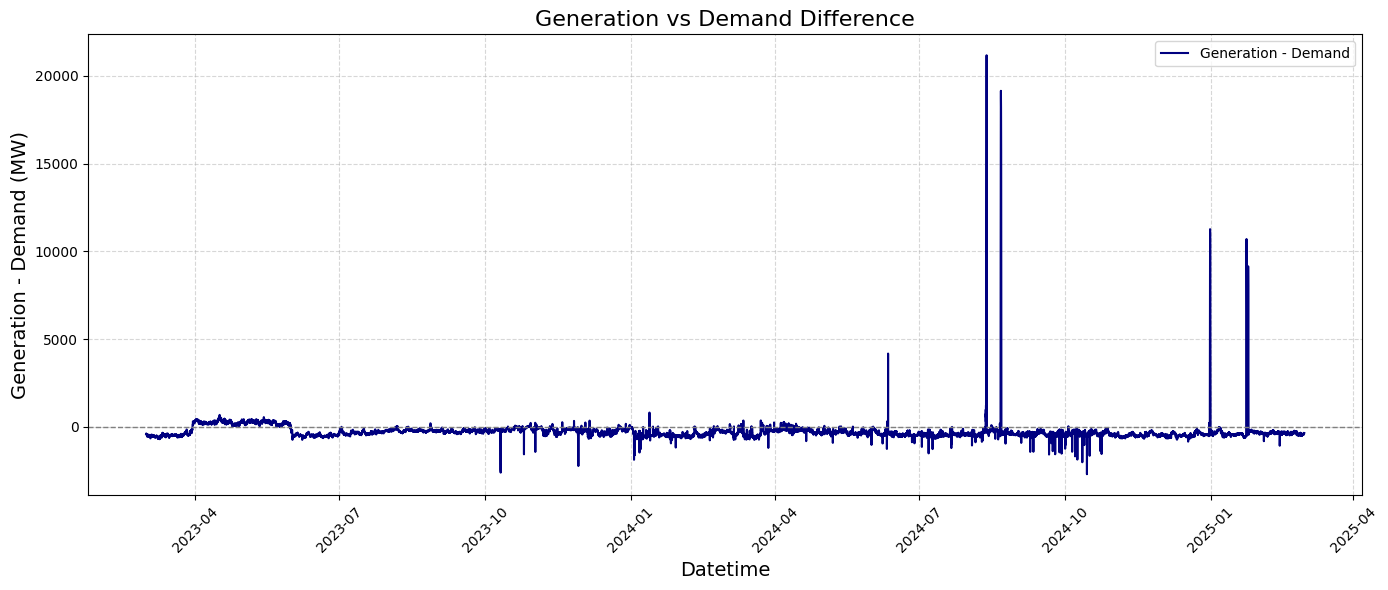

In [ ]:
# Adjust dataframe as per your original method
df['generation_demand_diff'] = df['gen_total'] - df['demand']

# Plot function consistent with your indexing
def plot_generation_demand_diff(df, title="Generation vs Demand Difference"):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['generation_demand_diff'], label='Generation - Demand', color='navy')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    plt.title(title, fontsize=16)
    plt.xlabel('Datetime', fontsize=14)
    plt.ylabel('Generation - Demand (MW)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_generation_demand_diff(df)


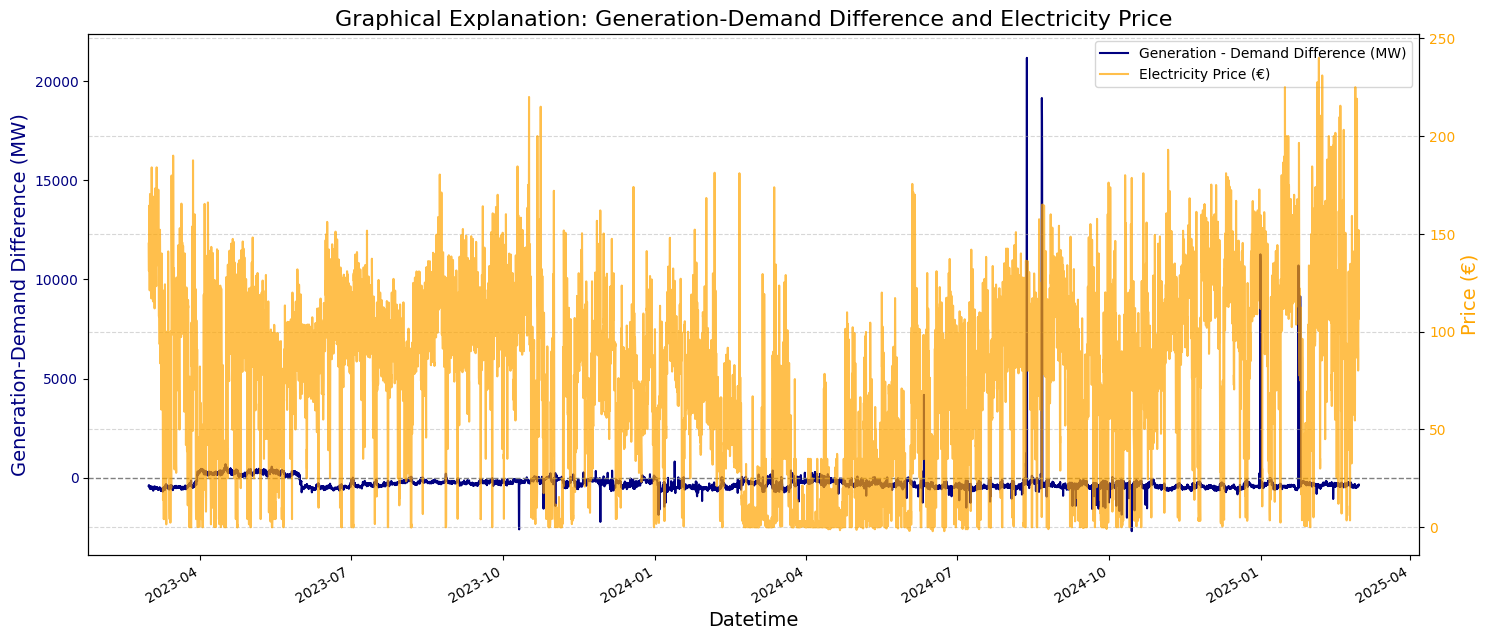

In [ ]:
import matplotlib.pyplot as plt

def plot_diff_vs_price(df):
    fig, ax1 = plt.subplots(figsize=(15, 7))

    # Plot generation-demand difference
    ax1.plot(df.index, df['generation_demand_diff'], color='navy', label='Generation - Demand Difference (MW)')
    ax1.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax1.set_xlabel('Datetime', fontsize=14)
    ax1.set_ylabel('Generation-Demand Difference (MW)', fontsize=14, color='navy')
    ax1.tick_params(axis='y', labelcolor='navy')

    # Secondary y-axis for price
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['price'], color='orange', alpha=0.7, label='Electricity Price (€)')
    ax2.set_ylabel('Price (€)', fontsize=14, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Titles and legends
    plt.title('Graphical Explanation: Generation-Demand Difference and Electricity Price', fontsize=16)
    fig.tight_layout()
    fig.autofmt_xdate()

    # Legends for both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example usage:
plot_diff_vs_price(df)


In [ ]:
!pip install jupyter-dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
with open("/content/drive/My Drive/BigDataProject/dash_app.py", "w") as f:
    f.write(dash_app_code)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/BigDataProject/dash_app.py'

In [ ]:
!python /content/drive/My\ Drive/BigDataProject/dash_app.py

python3: can't open file '/content/drive/My Drive/BigDataProject/dash_app.py': [Errno 2] No such file or directory


ANOMALY DETECTION

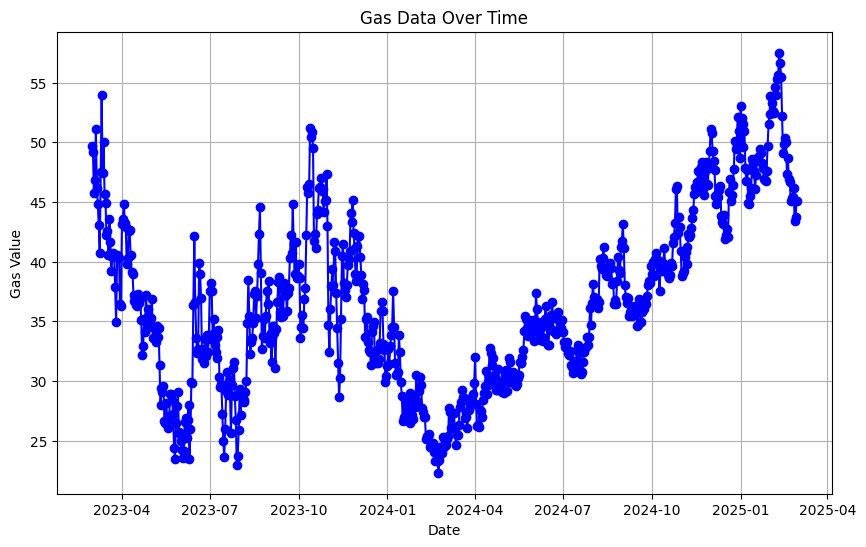

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
df = pd.read_excel("GAS_FILTRADO.xlsx")

# Convert the 'Date' column to datetime, if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Create a line plot of Gas data over time
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['price'], marker='o', linestyle='-', color='blue')
plt.title("Gas Data Over Time")
plt.xlabel("Date")
plt.ylabel("Gas Value")
plt.grid(True)
plt.show()


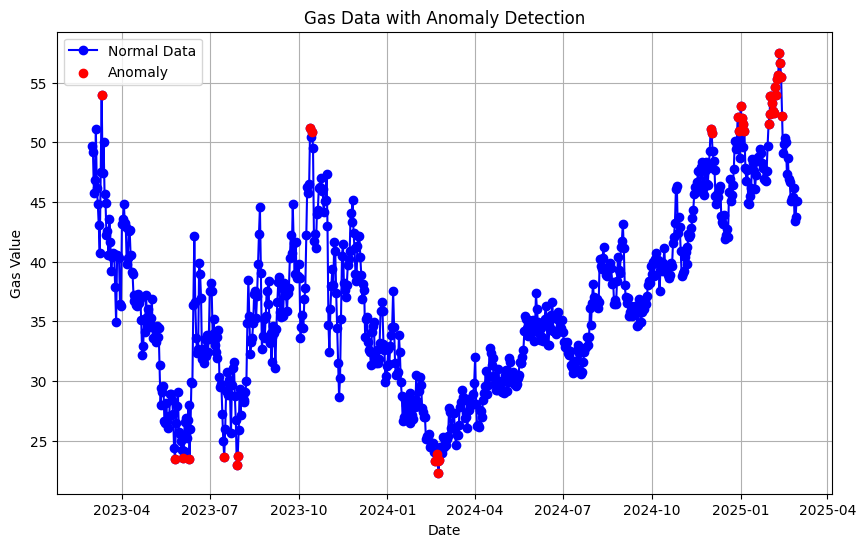

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Load the data
df = pd.read_excel("GAS_FILTRADO.xlsx")

# 2. Rename columns if necessary
# For example, if your columns are named "Fecha" and "GAS", do:
# df.rename(columns={"Fecha": "Date", "GAS": "Gas"}, inplace=True)

# 3. Convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# 4. Drop any rows with missing values in the 'Gas' column
df_clean = df.dropna(subset=["price"])

# 5. Prepare the data for anomaly detection
X = df_clean["price"].values.reshape(-1, 1)

# 6. Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(
    contamination=0.05,  # Adjust based on the expected proportion of anomalies
    random_state=42
)
df_clean["anomaly"] = iso_forest.fit_predict(X)

# 7. Filter out the anomalies
anomalies = df_clean[df_clean["anomaly"] == -1]

# 8. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_clean["Date"], df_clean["price"], color="blue", label="Normal Data", marker='o', linestyle='-')
plt.scatter(anomalies["Date"], anomalies["price"], color="red", label="Anomaly", zorder=5)
plt.title("Gas Data with Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Gas Value")
plt.legend()
plt.grid(True)
plt.show()
